# Laboratorio 3 - MLFLow & Feast

Diego Andrés Alonzo Medinilla - 20172

## Configuración del entorno

### Instalación de dependencias

In [1]:
%pip install mlflow feast scikit-learn pandas numpy matplotlib seaborn

  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
INFO: pip is looking at multiple versions of feast to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of feast to determine which version is compatible with other requirements. This could take a while.
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached rfc3339_validator-0.1.4-py2.py3-none-any.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 233.3 kB/s  0:00:36m0:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 269.6 kB/s  0:00:09 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 214.1 kB/s  0:00:05 eta 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.

In [2]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Verificación de la instalación

In [1]:
import mlflow
import feast

print(mlflow.__version__)
print(feast.__version__)

3.5.0
0.47.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlflow import MlflowClient
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor

## Carga y exploración del dataset

### Carga del dataset

In [23]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
# TODO: Cargar el dataset
housing = fetch_california_housing()
# TODO: Convertir a DataFrame con nombres de columnas apropiados
df = pd.DataFrame(housing['data'])
df = df.rename(
    {
        0:'MedInc',
        1:'HouseAge',
        2:'AveRooms',
        3:'AveBedrms',
        4:'Population',
        5:'AveOccup',
        6:'Latitude',
        7:'Longitude',
        # 8:'MedHouseVal' # There is no MedHouseVal in the doc
    }, 
    axis=1)
df['MedHouseVal'] = housing['target']

In [24]:
# TODO: Mostrar las primeras 5 filas
df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [25]:
# TODO: Mostrar información básica del dataset (shape, tipos de datos)
print(df.shape)
print(df.info())
df.describe()

(20640, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### Análisis Exploratorio

In [26]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [27]:
for col in df.columns:
    print(f"{col} has # {df[df[col].isna()].shape[0]} nulls")

MedInc has # 0 nulls
HouseAge has # 0 nulls
AveRooms has # 0 nulls
AveBedrms has # 0 nulls
Population has # 0 nulls
AveOccup has # 0 nulls
Latitude has # 0 nulls
Longitude has # 0 nulls
MedHouseVal has # 0 nulls


array([[<Axes: title={'center': 'MedHouseVal'}>]], dtype=object)

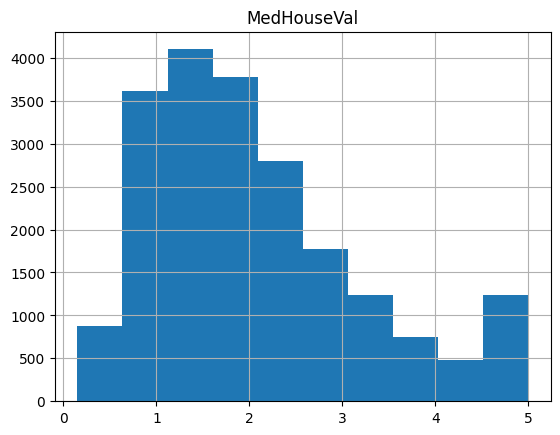

In [29]:
df.hist('MedHouseVal')

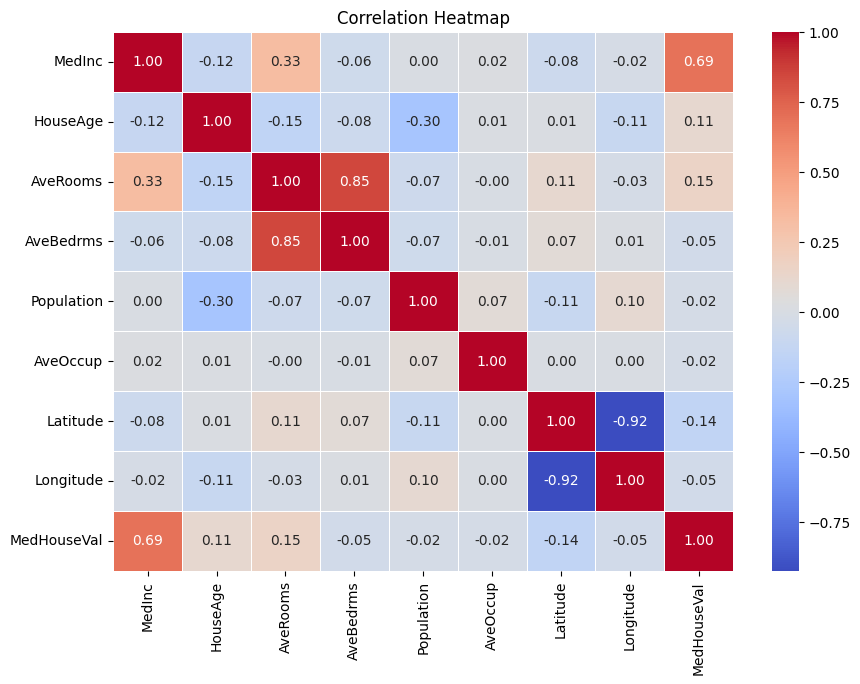

In [31]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## Preparación de los Datos

### División de datos

In [36]:
from sklearn.model_selection import train_test_split

# TODO: Separar features (X) y target (y)
# TODO: Dividir en train y test con random_state=42
X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(df[df.columns[:-1]]), 
    np.array(df[df.columns[-1]]),
    test_size=0.2, 
    random_state=42
)

### Feature Engineering

In [42]:
# TODO: Crear features derivadas

## Ingreso medio por persona por la vivienda MedInc/AveOccup
df['MedPP'] = df['MedInc']/df['AveOccup']
## Razon de dormitorios por habitación AveBedrms/AveRooms
df['RatioRoomsBed'] = df['AveBedrms']/df['AveRooms']
## Población total en el distrito = Pt M = Pt/Viviendas => M*Pt = Viviendas por distrito
df['HouseP'] = df['AveOccup'] * df['Population']

df = df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedPP', 'RatioRoomsBed',
       'HouseP', 'MedHouseVal']]
# TODO: Actualizar los conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(df[df.columns[:-1]]), 
    np.array(df[df.columns[-1]]),
    test_size=0.2, 
    random_state=42
)

## Experimentación con MLFlow

### Configuración de MLFlow

### Entrenamiento de modelos

## Feature Store con Feast

### Configuración de Feast

### Definición de Features

### Materialización de Features

### Consumo de Features